In [2]:
import tensorflow as tf
from backbone.blocks.resnet_block import identity_block, convolutional_block, conv_first_block

# Build model
- Btw you can pull and check from tf.keras.applications (to tell if the params are the same)
- Note: Unlike tf keras applications, this version allows any input shape of your choosing

In [18]:
def Resnet101(input_shape=(224, 224, 3)):
    # Stage 1
    x, input_layer = conv_first_block(input_shape=input_shape)
    
    # Stage 2
    x = convolutional_block(x, [64, 64, 256], (3, 3), strides=(1, 1))
    x = identity_block(x, [64, 64, 256], (3, 3))
    x = identity_block(x, [64, 64, 256], (3, 3))
    
    # Stage 3
    x = convolutional_block(x, [128, 128, 512], (3, 3), strides=(2, 2))
    x = identity_block(x, [128, 128, 512], (3, 3))
    x = identity_block(x, [128, 128, 512], (3, 3))
    x = identity_block(x, [128, 128, 512], (3, 3))
    
    # Stage 4
    x = convolutional_block(x, [256, 256, 1024], (3, 3), strides=(2, 2))
    # Use a for loop to add the blocks - too many times to copy and paste
    for i in range(22):
        x = identity_block(x, [256, 256, 1024], (3,3))
        
    # Stage 5
    x = convolutional_block(x, [512, 512, 2048], (3, 3), strides=(2, 2))
    x = identity_block(x, [512, 512, 2048], (3, 3))
    x = identity_block(x, [512, 512, 2048], (3, 3))
    
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    return tf.keras.Model(inputs=input_layer, outputs=x, name='Resnet101')

In [8]:
def Resnet152(input_shape=(224, 224, 3)):
    # Stage 1
    x, input_layer = conv_first_block(input_shape=input_shape)
    
    # Stage 2 
    x = convolutional_block(x, [64, 64, 256], (3, 3), strides=(1, 1))
    x = identity_block(x, [64, 64, 256], (3, 3))
    x = identity_block(x, [64, 64, 256], (3, 3))
    
    # Stage 3 - Requires 8 blocks (use for loop instead of copying and pasting)
    x = convolutional_block(x, [128, 128, 512], (3, 3), strides=(2, 2))
    for i in range(7):
        x = identity_block(x, [128, 128, 512], (3, 3))
            
    # Stage 4 - Requires 36 blocks
    x = convolutional_block(x, [256, 256, 1024], (3, 3), strides=(2, 2))
    for i in range(35):
        x = identity_block(x, [256, 256, 1024], (3, 3))
    
    # Stage 5
    x = convolutional_block(x, [512, 512, 2048], (3, 3), strides=(2, 2))
    x = identity_block(x, [512, 512, 2048], (3, 3))
    x = identity_block(x, [512, 512, 2048], (3, 3))
    
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    return tf.keras.Model(inputs=input_layer, outputs=x, name='Resnet152')

# Train on mnist again

In [13]:
# You can buld a model on top of resnet using a sequential model as such
model = tf.keras.Sequential()
model.add(Resnet152(input_shape=(28, 28, 1)))
model.add(tf.keras.layers.Dense(64))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.Dense(10))
model.add(tf.keras.layers.Activation('softmax'))

In [14]:
from matplotlib import pyplot as plt

In [15]:
(train_img, train_label), (test_img, test_label) = tf.keras.datasets.mnist.load_data()

In [16]:
def preproc_img(img, label):
    img = tf.cast(img, tf.float32)
    img = img / 255.
    
    return img, tf.one_hot(label, 10)

In [17]:
epochs = 10
batch_size = 128
learning_rate = 1e-4

In [18]:
train_data = tf.data.Dataset.from_tensor_slices((train_img, train_label))
train_data = train_data.map(preproc_img)
train_data = train_data.cache()
train_data = train_data.shuffle(len(train_img))
train_data = train_data.repeat(1)
train_data = train_data.batch(batch_size, drop_remainder=True)
train_data = train_data.prefetch(tf.data.experimental.AUTOTUNE)

In [19]:
test_data = tf.data.Dataset.from_tensor_slices((test_img, test_label))
test_data = test_data.map(preproc_img)
test_data = test_data.cache()
train_data = train_data.repeat(1)
test_data = test_data.batch(batch_size)
test_data = test_data.prefetch(tf.data.experimental.AUTOTUNE)

In [20]:
model.compile(
    tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss='categorical_crossentropy', metrics=['accuracy']
)

In [21]:
history = model.fit(
    train_data,
    epochs=epochs,
    validation_data=test_data
)

Epoch 1/10
468/468 [==============================] - 62s 132ms/step - loss: 2.2347 - accuracy: 0.1716 - val_loss: 2.4117 - val_accuracy: 0.1669
Epoch 2/10
468/468 [==============================] - 61s 130ms/step - loss: 1.7439 - accuracy: 0.3674 - val_loss: 1.2832 - val_accuracy: 0.5605
Epoch 3/10
468/468 [==============================] - 61s 130ms/step - loss: 1.1302 - accuracy: 0.6165 - val_loss: 0.7589 - val_accuracy: 0.7533
Epoch 4/10
468/468 [==============================] - 61s 130ms/step - loss: 0.7048 - accuracy: 0.7871 - val_loss: 0.5160 - val_accuracy: 0.8517
Epoch 5/10
468/468 [==============================] - 60s 128ms/step - loss: 0.4840 - accuracy: 0.8598 - val_loss: 0.4908 - val_accuracy: 0.8799
Epoch 6/10
468/468 [==============================] - 62s 132ms/step - loss: 0.3380 - accuracy: 0.9057 - val_loss: 0.3716 - val_accuracy: 0.8995
Epoch 7/10
468/468 [==============================] - 61s 130ms/step - loss: 0.2591 - accuracy: 0.9296 - val_loss: 0.2905 - val_ac

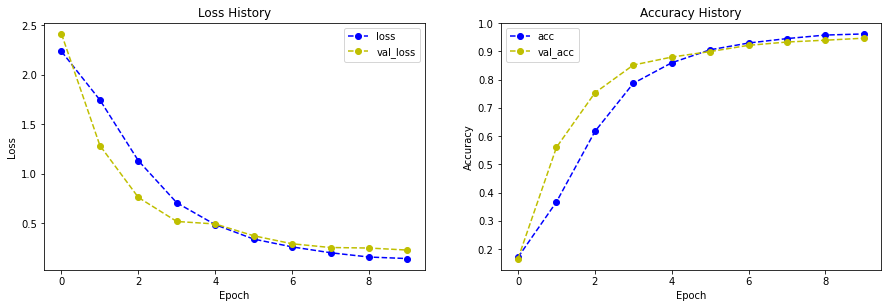

In [22]:
plt.figure(figsize=(15, 10))
plt.subplot(221)
plt.title('Loss History')
plt.plot(history.history['loss'], '--bo',label='loss')
plt.plot(history.history['val_loss'], '--yo',label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(222)
plt.title('Accuracy History')
plt.plot(history.history['accuracy'], '--bo',label='acc')
plt.plot(history.history['val_accuracy'], '--yo',label='val_acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Evaluate

In [23]:
from sklearn.metrics import classification_report, confusion_matrix, matthews_corrcoef
import seaborn as sns

In [24]:
y_true = test_label
y_pred = model.predict(test_data)
y_pred = y_pred.argmax(axis=1)

              precision    recall  f1-score   support

           0       0.96      0.97      0.97       980
           1       0.98      0.99      0.99      1135
           2       0.93      0.95      0.94      1032
           3       0.94      0.95      0.94      1010
           4       0.96      0.94      0.95       982
           5       0.92      0.94      0.93       892
           6       0.98      0.94      0.96       958
           7       0.95      0.94      0.94      1028
           8       0.94      0.91      0.92       974
           9       0.91      0.94      0.92      1009

    accuracy                           0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000

MCC :94.08


<AxesSubplot:>

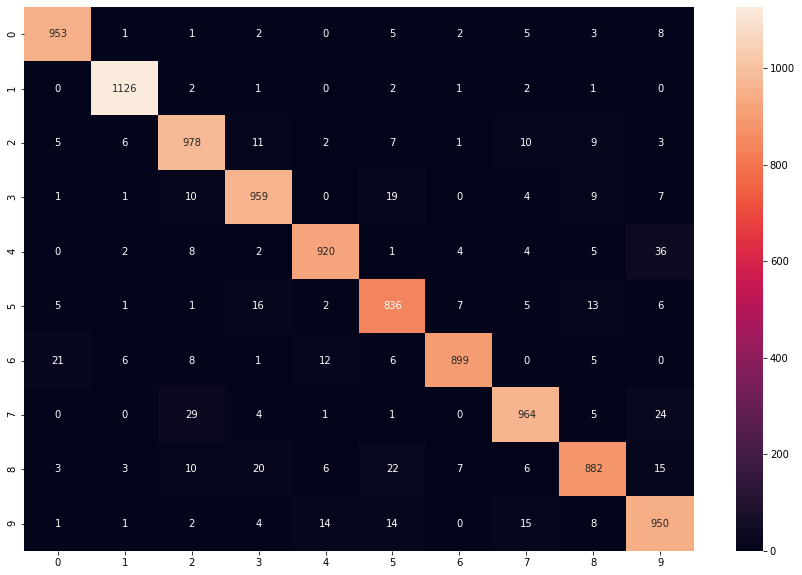

In [25]:
print(classification_report(y_true, y_pred))
print('MCC :{}'.format(round(matthews_corrcoef(y_true, y_pred) * 100, 2)))
conf_mat = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(15, 10))
sns.heatmap(
    conf_mat, annot=True, fmt=''
)